# Benchmarking large-scale integration

Here we walkthrough applying the integration benchmarking metrics on a dataset of non-small cell lung cancer from the following paper:

Salcher, S., Sturm, G., Horvath, L., Untergasser, G., Kuempers, C., Fotakis, G., ... & Trajanoski, Z. (2022). High-resolution single-cell atlas reveals diversity and plasticity of tissue-resident neutrophils in non-small cell lung cancer. Cancer Cell.

This dataset contains ~900,000 cells, so here we demonstrate the scalbility of the metrics here on large data.

In [ ]:
import numpy as np
import scanpy as sc
from scvi.data import cellxgene

from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

%matplotlib inline

## Load and preprocess data

In [ ]:
url = "https://cellxgene.cziscience.com/e/232f6a5a-a04c-4758-a6e8-88ab2e3a6e69.cxg/"
adata = cellxgene(url, filename="luca.h5ad", save_path="data/")

In [ ]:
adata

AnnData object with n_obs × n_vars = 892296 × 17811
    obs: 'sample', 'uicc_stage', 'ever_smoker', 'age', 'donor_id', 'origin', 'dataset', 'ann_fine', 'cell_type_predicted', 'doublet_status', 'leiden', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'ann_coarse', 'cell_type_tumor', 'tumor_stage', 'EGFR_mutation', 'TP53_mutation', 'ALK_mutation', 'BRAF_mutation', 'ERBB2_mutation', 'KRAS_mutation', 'ROS_mutation', 'origin_fine', 'study', 'platform', 'cell_type_major', 'suspension_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'is_highly_variable', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total

In [ ]:
sc.pp.subsample(adata, n_obs=500_000)

In [ ]:
# Number of unique cell types
adata.obs["cell_type"].nunique()

33

In [ ]:
adata.var["highly_variable"] = np.asarray(adata.var["is_highly_variable"].astype(bool))
sc.tl.pca(adata)

## "Run" methods

The authors used scVI and scANVI in their manuscript, and these embeddings are already stored in the AnnData object. We can use these to run the metrics.

### scVI

In [ ]:
adata.obsm["scVI"] = adata.obsm["X_scVI"]

### scANVI

In [ ]:
adata.obsm["scANVI"] = adata.obsm["X_scANVI"]

## Perform the benchmark

Here we use a custom nearest neighbor function to speed up the computation of the metrics. This is not necessary, but can be useful for large datasets.

In particular we use [faiss](https://github.com/facebookresearch/faiss), which can be accelerated with a GPU.

This can be installed as

```bash
conda install -c conda-forge faiss-gpu
```

When using approximate nearest neighbors, an issue can arise where each cell does not get a unique set of K neighbors. This issue happens with faiss hnsw below, so we use the brute force method instead, which is still faster than pynndescent approximate nearest neighbors on CPU.

In [ ]:
import faiss

from scib_metrics.nearest_neighbors import NeighborsResults


def faiss_hnsw_nn(X: np.ndarray, k: int):
    """Gpu HNSW nearest neighbor search using faiss.

    See https://github.com/nmslib/hnswlib/blob/master/ALGO_PARAMS.md
    for index param details.
    """
    X = np.ascontiguousarray(X, dtype=np.float32)
    res = faiss.StandardGpuResources()
    M = 32
    index = faiss.IndexHNSWFlat(X.shape[1], M, faiss.METRIC_L2)
    gpu_index = faiss.index_cpu_to_gpu(res, 0, index)
    gpu_index.add(X)
    distances, indices = gpu_index.search(X, k)
    del index
    del gpu_index
    # distances are squared
    return NeighborsResults(indices=indices, distances=np.sqrt(distances))


def faiss_brute_force_nn(X: np.ndarray, k: int):
    """Gpu brute force nearest neighbor search using faiss."""
    X = np.ascontiguousarray(X, dtype=np.float32)
    res = faiss.StandardGpuResources()
    index = faiss.IndexFlatL2(X.shape[1])
    gpu_index = faiss.index_cpu_to_gpu(res, 0, index)
    gpu_index.add(X)
    distances, indices = gpu_index.search(X, k)
    del index
    del gpu_index
    # distances are squared
    return NeighborsResults(indices=indices, distances=np.sqrt(distances))

In [ ]:
import time

adata.obsm["Unintegrated"] = adata.obsm["X_pca"]

biocons = BioConservation(isolated_labels=False)

start = time.time()
bm = Benchmarker(
    adata,
    batch_key="sample",
    label_key="cell_type",
    embedding_obsm_keys=["Unintegrated", "scANVI", "scVI"],
    pre_integrated_embedding_obsm_key="X_pca",
    bio_conservation_metrics=biocons,
    batch_correction_metrics=BatchCorrection(),
    n_jobs=-1,
)
bm.prepare(neighbor_computer=faiss_brute_force_nn)
bm.benchmark()
end = time.time()
print(f"Time: {int((end - start) / 60)} min {int((end - start) % 60)} sec")

Computing neighbors:   0%|          | 0/3 [00:00<?, ?it/s]

Embeddings: 100%|██████████| 3/3 [20:19<00:00, 406.57s/it]


Time: 20 min 45 sec


### Visualize the results

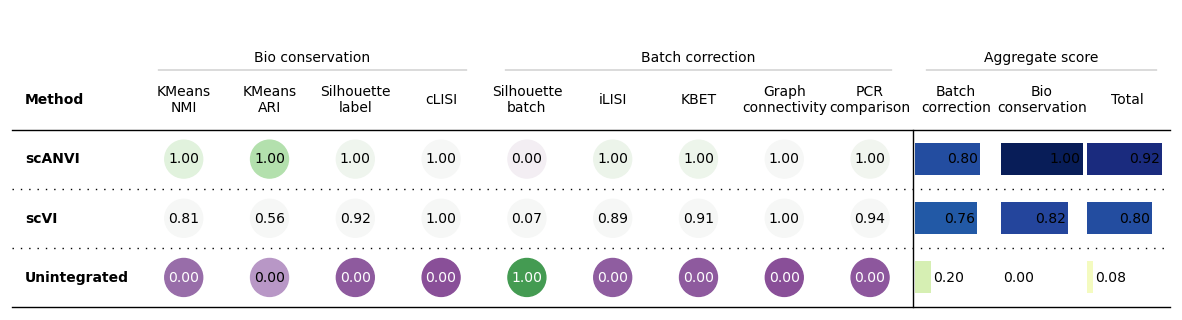

In [ ]:
bm.plot_results_table()

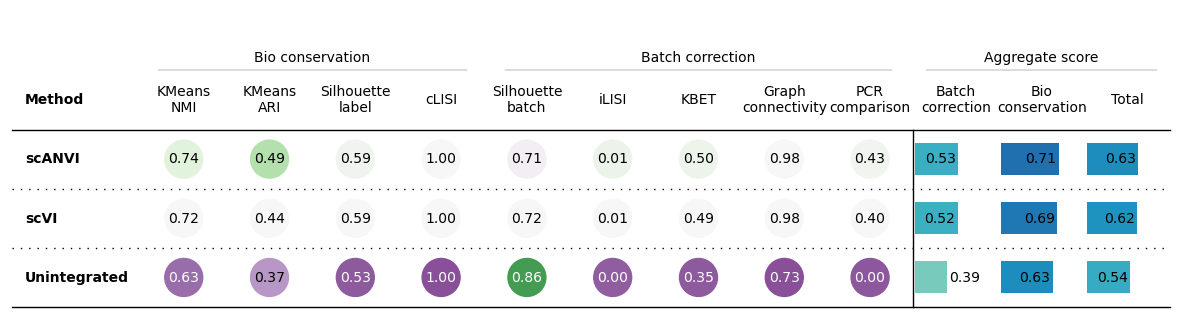

In [ ]:
bm.plot_results_table(min_max_scale=False)

We can also access the underlying dataframes to print the results ourselves.

In [ ]:
from rich import print

df = bm.get_results(min_max_scale=False)
print(df)

KMeans NMI        KMeans ARI  Silhouette label  \
Embedding                                                            
Unintegrated          0.630967          0.372678          0.531423   
scANVI                0.744273          0.485717          0.594908   
scVI                  0.722253          0.435955          0.590104   
Metric Type   Bio conservation  Bio conservation  Bio conservation   

                         cLISI  Silhouette batch             iLISI  \
Embedding                                                            
Unintegrated          0.999528          0.861078          0.002044   
scANVI                     1.0          0.710921          0.009262   
scVI                       1.0          0.721547          0.008491   
Metric Type   Bio conservation  Batch correction  Batch correction   

                          KBET Graph connectivity    PCR comparison  \
Embedding                                                             
Unintegrated          0.350416           0.733284               0.0   
scANVI                0.504855           0.981208          0.428348   
scVI                  0.490899           0.980226          0.403148   
Metric Type   Batch correction   Batch correction  Batch correction   

             Batch correction Bio conservation            Total  
Embedding                                                        
Unintegrated         0.389365         0.633649         0.535935  
scANVI               0.526919         0.706225         0.634502  
scVI                 0.520862         0.687078         0.620592  
Metric Type   Aggregate score  Aggregate score  Aggregate score